# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn"])

In [2]:
from enum import Enum
import re
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

sns.set_style("ticks", {"axes.grid": True})

# Data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data')

In [4]:
radiation = Enum("rad_type", "proton Co60")
detector = Enum("detector", "mcp mts")

## Monte-Carlo results

In [5]:
df_mc = pd.read_csv(data_dir / "interim" / "mc.csv")
df_mc

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.227477,11.633363,35.385786,11.088739,11.119699,11.184843
1,0.1275,11.232338,11.724956,35.667142,11.088840,11.128653,11.201058
2,0.2125,11.234249,11.787788,36.679750,11.088901,11.135544,11.213373
3,0.2975,11.270811,11.869649,36.399744,11.128965,11.181241,11.259141
4,0.3825,11.277012,11.922945,37.028460,11.132754,11.190703,11.270034
...,...,...,...,...,...,...,...
395,33.6175,0.000000,95.157937,667.910476,0.000000,50.939122,64.914758
396,33.7025,0.000000,93.838051,666.153374,0.000000,49.928610,63.836474
397,33.7875,0.000000,93.075406,809.382192,0.000000,50.108000,68.220748
398,33.8725,0.000000,93.619083,611.994822,0.000000,50.774796,65.096386


In [6]:
# Reshaping the DataFrame using melt
df_melted = pd.melt(df_mc, id_vars="z_mm", var_name="LET_Type", value_name="LET")
df_melted["averaging"] = df_melted["LET_Type"].apply(lambda x: x[0])
df_melted["particles"] = df_melted["LET_Type"].apply(lambda x: x[4:])
df_melted = df_melted.drop(columns="LET_Type")
df_melted.LET /= 10
df_melted

,z_mm,LET,averaging,particles
0,0.0425,1.122748,d,Primaries
1,0.1275,1.123234,d,Primaries
2,0.2125,1.123425,d,Primaries
3,0.2975,1.127081,d,Primaries
4,0.3825,1.127701,d,Primaries
...,...,...,...,...
2395,33.6175,6.491476,t,All
2396,33.7025,6.383647,t,All
2397,33.7875,6.822075,t,All
2398,33.8725,6.509639,t,All


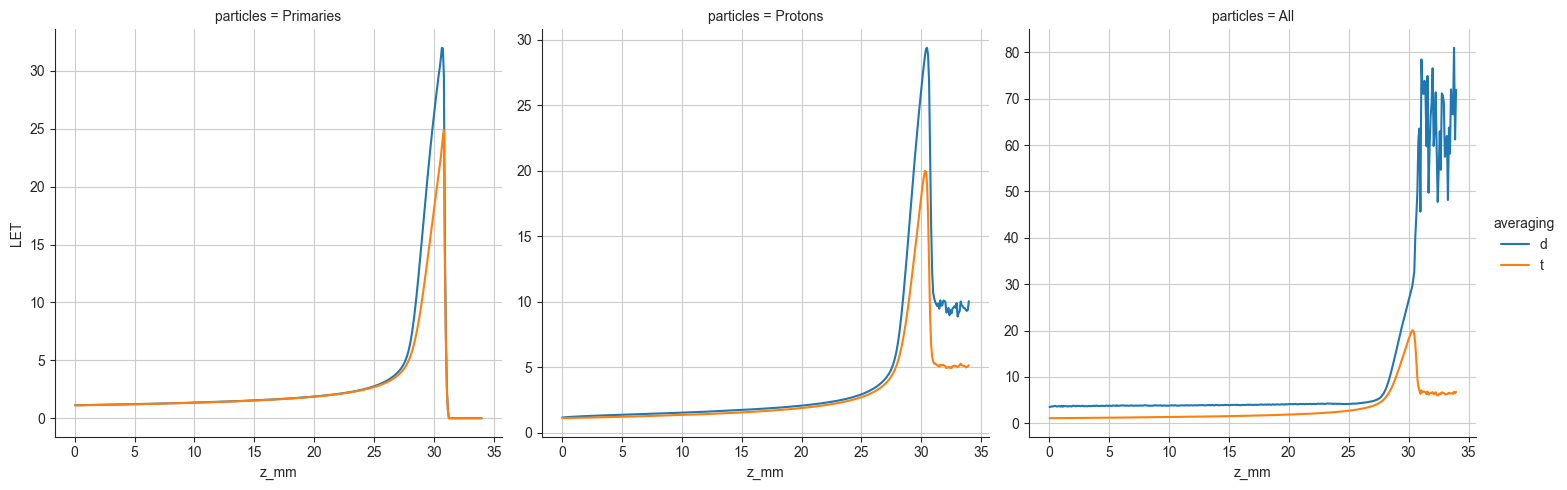

In [7]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="averaging", col="particles", kind="line", facet_kws=dict(sharey=False)
)

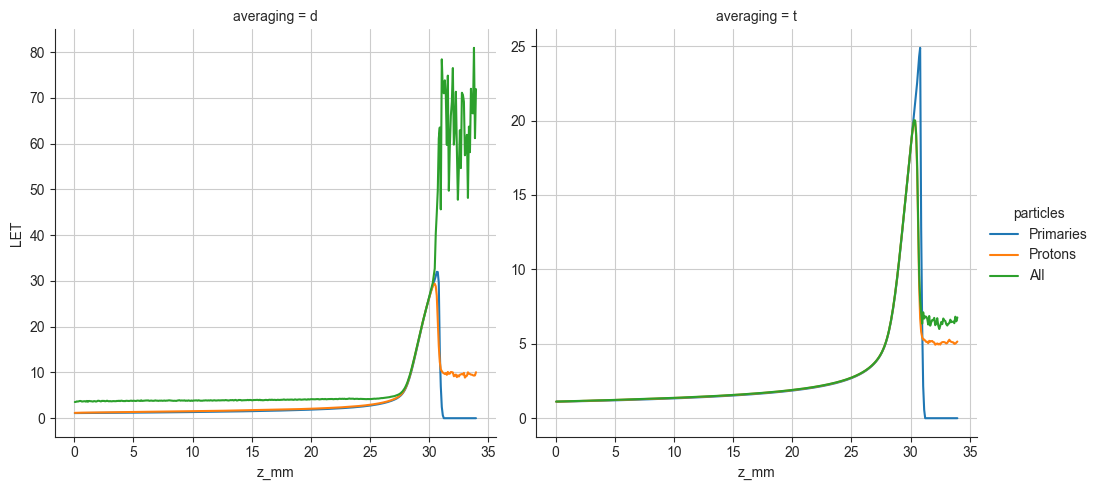

In [8]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="particles", col="averaging", kind="line", facet_kws=dict(sharey=False)
)

## Detector data

In [9]:
df_eff = pd.read_csv(data_dir / "interim" / "proton_eff.csv")
plexi_to_water = 1.16
shift = 1.2642
step_pmma = 0.00329
df_eff["z_mm"] = plexi_to_water * (shift + step_pmma * df_eff.pmma_wheel_steps)
df_eff

,detector,energy_MeV,pmma_wheel_steps,det_id,eff,z_mm
0,mts,4.92,6895,61,0.985627,27.780550
1,mts,4.92,6895,62,0.984895,27.780550
2,mts,4.92,6895,63,0.980375,27.780550
3,mts,4.92,6895,64,0.993604,27.780550
4,mts,4.92,6895,65,0.976298,27.780550
...,...,...,...,...,...,...
126,mcp,55.00,0,2,0.838465,1.466472
127,mcp,55.00,0,3,0.843554,1.466472
128,mcp,55.00,0,4,0.842029,1.466472
129,mcp,55.00,0,5,0.845122,1.466472


Text(0, 0.5, 'Efficiency')

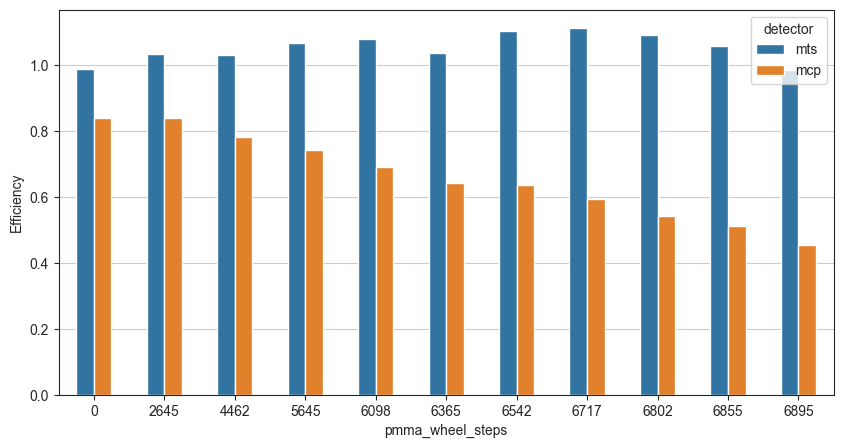

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_eff, x="pmma_wheel_steps", y="eff", hue="detector", errorbar=None, width=0.5, ax=ax)
ax.set_ylabel("Efficiency")

<Axes: xlabel='z_mm', ylabel='eff'>

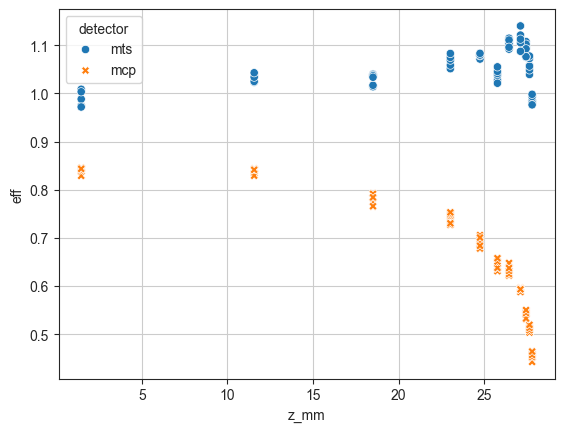

In [11]:
sns.scatterplot(data=df_eff, x="z_mm", y="eff", hue="detector", style="detector")

In [12]:
df_ratio = df_eff[df_eff.detector == detector.mcp.name].copy()
df_ratio.drop(columns=["energy_MeV", "pmma_wheel_steps", "detector"], inplace=True)
# rename eff to mcp_eff
df_ratio.rename(columns={"eff": "mcp_eff"}, inplace=True)
df_ratio = df_ratio.merge(
    df_eff[df_eff.detector == detector.mts.name][["z_mm", "eff"]], on="z_mm", suffixes=("_mcp", "_mts")
)
df_ratio.rename(columns={"eff": "mts_eff"}, inplace=True)
df_ratio["ratio"] = df_ratio.mts_eff / df_ratio.mcp_eff
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio
0,61,0.458801,27.780550,0.985627,2.148265
1,61,0.458801,27.780550,0.984895,2.146670
2,61,0.458801,27.780550,0.980375,2.136819
3,61,0.458801,27.780550,0.993604,2.165651
4,61,0.458801,27.780550,0.976298,2.127932
...,...,...,...,...,...
385,6,0.843410,1.466472,0.974666,1.155625
386,6,0.843410,1.466472,0.988239,1.171718
387,6,0.843410,1.466472,0.971826,1.152258
388,6,0.843410,1.466472,1.008711,1.195990


<Axes: xlabel='z_mm', ylabel='ratio'>

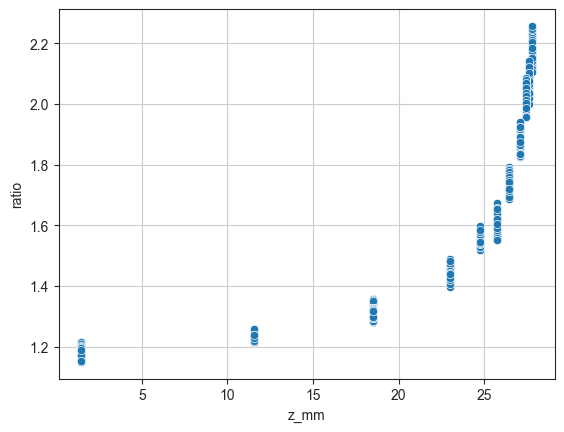

In [13]:
sns.scatterplot(data=df_ratio, x="z_mm", y="ratio")

In [14]:
from scipy.interpolate import griddata


# Define function for interpolation
def interpolate_let(df, averaging, particles, z_mm):
    subset = df[(df["averaging"] == averaging) & (df["particles"] == particles)]

    if len(subset) == 0:
        raise ValueError("No matching rows found for the given averaging and particles.")

    points = subset[["z_mm"]].values
    values = subset["LET"].values

    interpolated_value = griddata(points, values, z_mm, method="linear")

    return interpolated_value  # Assuming you want a single value as the result


# Example usage
averaging_value = "d"
particles_value = "Primaries"
z_mm_value = 2  # Replace this with the desired z_mm value

interpolated_let = interpolate_let(df_melted, averaging_value, particles_value, z_mm_value)
print(f"Interpolated LET value: {interpolated_let}")

Interpolated LET value: 1.1549634573076464


In [15]:
interpolate_let(df_melted, averaging_value, particles_value, df_eff.z_mm.values)

array([5.51897645, 5.51897645, 5.51897645, 5.51897645, 5.51897645,
       5.51897645, 5.05056083, 5.05056083, 5.05056083, 5.05056083,
       5.05056083, 5.05056083, 4.59923485, 4.59923485, 4.59923485,
       4.59923485, 4.59923485, 4.59923485, 4.11589989, 4.11589989,
       4.11589989, 4.11589989, 4.11589989, 4.11589989, 3.49107068,
       3.49107068, 3.49107068, 3.49107068, 3.49107068, 3.49107068,
       3.08264016, 3.08264016, 3.08264016, 3.08264016, 3.08264016,
       3.08264016, 2.67340201, 2.67340201, 2.67340201, 2.67340201,
       2.67340201, 2.67340201, 2.25990842, 2.25990842, 2.25990842,
       2.25990842, 2.25990842, 2.25990842, 1.74738008, 1.74738008,
       1.74738008, 1.74738008, 1.74738008, 1.74738008, 1.3979991 ,
       1.3979991 , 1.3979991 , 1.3979991 , 1.3979991 , 1.3979991 ,
       1.14549852, 1.14549852, 1.14549852, 1.14549852, 1.14549852,
       5.51897645, 5.51897645, 5.51897645, 5.51897645, 5.51897645,
       5.51897645, 5.05056083, 5.05056083, 5.05056083, 5.05056

In [16]:
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_eff[f"{av}LET{part}"] = interpolate_let(df_melted, av, part, df_eff.z_mm.values)
df_eff

,detector,energy_MeV,pmma_wheel_steps,det_id,eff,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,mts,4.92,6895,61,0.985627,27.780550,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
1,mts,4.92,6895,62,0.984895,27.780550,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
2,mts,4.92,6895,63,0.980375,27.780550,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
3,mts,4.92,6895,64,0.993604,27.780550,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
4,mts,4.92,6895,65,0.976298,27.780550,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
...,...,...,...,...,...,...,...,...,...,...,...,...
126,mcp,55.00,0,2,0.838465,1.466472,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
127,mcp,55.00,0,3,0.843554,1.466472,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
128,mcp,55.00,0,4,0.842029,1.466472,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
129,mcp,55.00,0,5,0.845122,1.466472,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058


<Axes: xlabel='dLETProtons', ylabel='eff'>

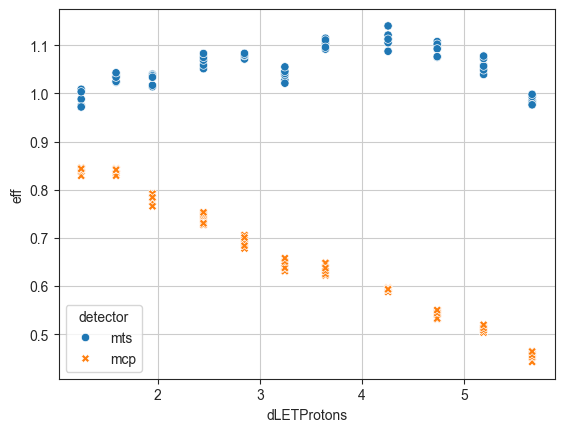

In [17]:
sns.scatterplot(data=df_eff, x="dLETProtons", y="eff", hue="detector", style="detector")

In [18]:
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_ratio[f"{av}LET{part}"] = interpolate_let(df_melted, av, part, df_ratio.z_mm.values)
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,61,0.458801,27.780550,0.985627,2.148265,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
1,61,0.458801,27.780550,0.984895,2.146670,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
2,61,0.458801,27.780550,0.980375,2.136819,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
3,61,0.458801,27.780550,0.993604,2.165651,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
4,61,0.458801,27.780550,0.976298,2.127932,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
...,...,...,...,...,...,...,...,...,...,...,...
385,6,0.843410,1.466472,0.974666,1.155625,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
386,6,0.843410,1.466472,0.988239,1.171718,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
387,6,0.843410,1.466472,0.971826,1.152258,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
388,6,0.843410,1.466472,1.008711,1.195990,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058


<Axes: xlabel='dLETProtons', ylabel='ratio'>

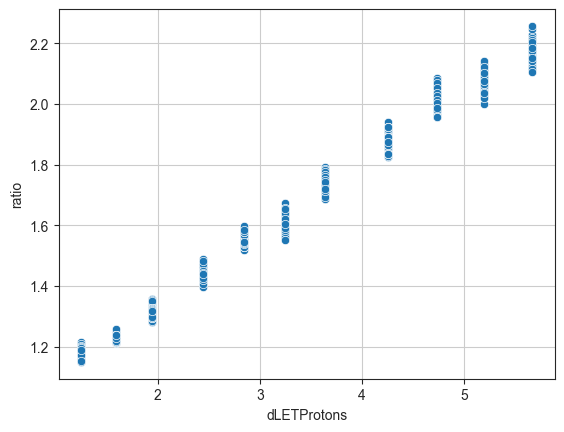

In [19]:
sns.scatterplot(data=df_ratio, x="dLETProtons", y="ratio")

In [20]:
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,61,0.458801,27.780550,0.985627,2.148265,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
1,61,0.458801,27.780550,0.984895,2.146670,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
2,61,0.458801,27.780550,0.980375,2.136819,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
3,61,0.458801,27.780550,0.993604,2.165651,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
4,61,0.458801,27.780550,0.976298,2.127932,5.518976,5.665975,5.976118,4.778425,4.809622,4.812614
...,...,...,...,...,...,...,...,...,...,...,...
385,6,0.843410,1.466472,0.974666,1.155625,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
386,6,0.843410,1.466472,0.988239,1.171718,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
387,6,0.843410,1.466472,0.971826,1.152258,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058
388,6,0.843410,1.466472,1.008711,1.195990,1.145499,1.250195,3.685241,1.131168,1.141920,1.150058


In [21]:
# Reshaping the DataFrame using melt
df_ratio_melted = pd.melt(
    df_ratio, id_vars=["z_mm", "det_id", "mcp_eff", "mts_eff", "ratio"], var_name="LET_Type", value_name="LET"
)
df_ratio_melted["averaging"] = df_ratio_melted["LET_Type"].apply(lambda x: x[0])
df_ratio_melted["particles"] = df_ratio_melted["LET_Type"].apply(lambda x: x[4:])
df_ratio_melted = df_ratio_melted.drop(columns="LET_Type")
df_ratio_melted

,z_mm,det_id,mcp_eff,mts_eff,ratio,LET,averaging,particles
0,27.780550,61,0.458801,0.985627,2.148265,5.518976,d,Primaries
1,27.780550,61,0.458801,0.984895,2.146670,5.518976,d,Primaries
2,27.780550,61,0.458801,0.980375,2.136819,5.518976,d,Primaries
3,27.780550,61,0.458801,0.993604,2.165651,5.518976,d,Primaries
4,27.780550,61,0.458801,0.976298,2.127932,5.518976,d,Primaries
...,...,...,...,...,...,...,...,...
2335,1.466472,6,0.843410,0.974666,1.155625,1.150058,t,All
2336,1.466472,6,0.843410,0.988239,1.171718,1.150058,t,All
2337,1.466472,6,0.843410,0.971826,1.152258,1.150058,t,All
2338,1.466472,6,0.843410,1.008711,1.195990,1.150058,t,All


In [22]:
df_ratio_melted.averaging.unique()

array(['d', 't'], dtype=object)

In [23]:
df_ratio_melted.particles.unique()

array(['Primaries', 'Protons', 'All'], dtype=object)

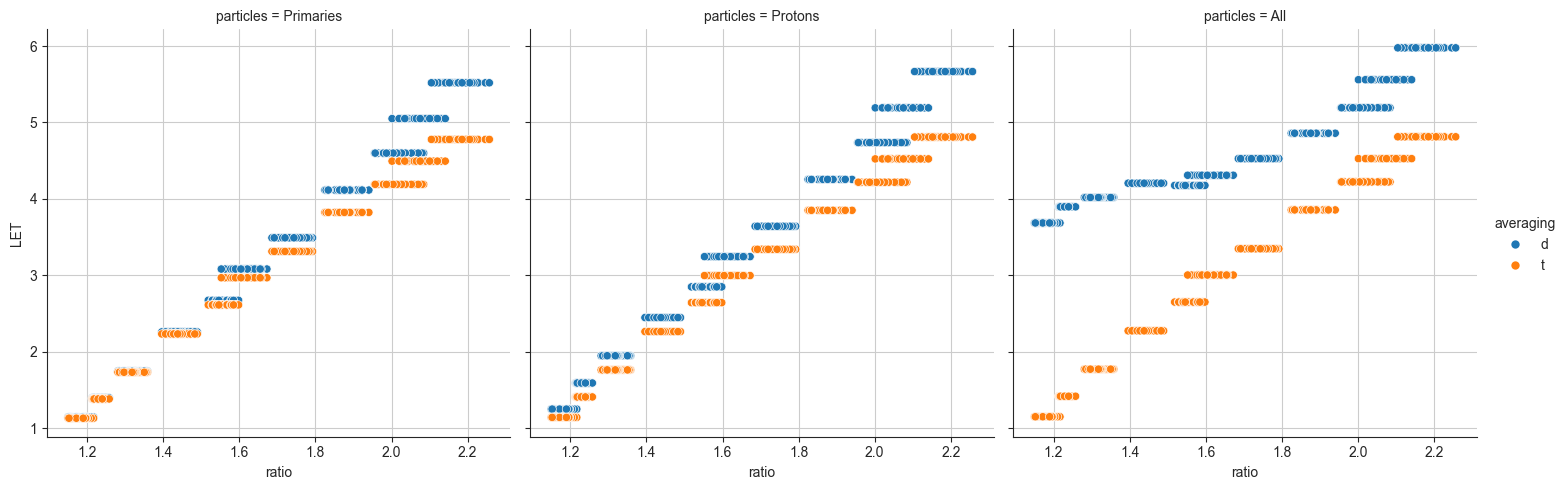

In [24]:
sns.relplot(data=df_ratio_melted, x="ratio", y="LET", hue="averaging", col="particles")

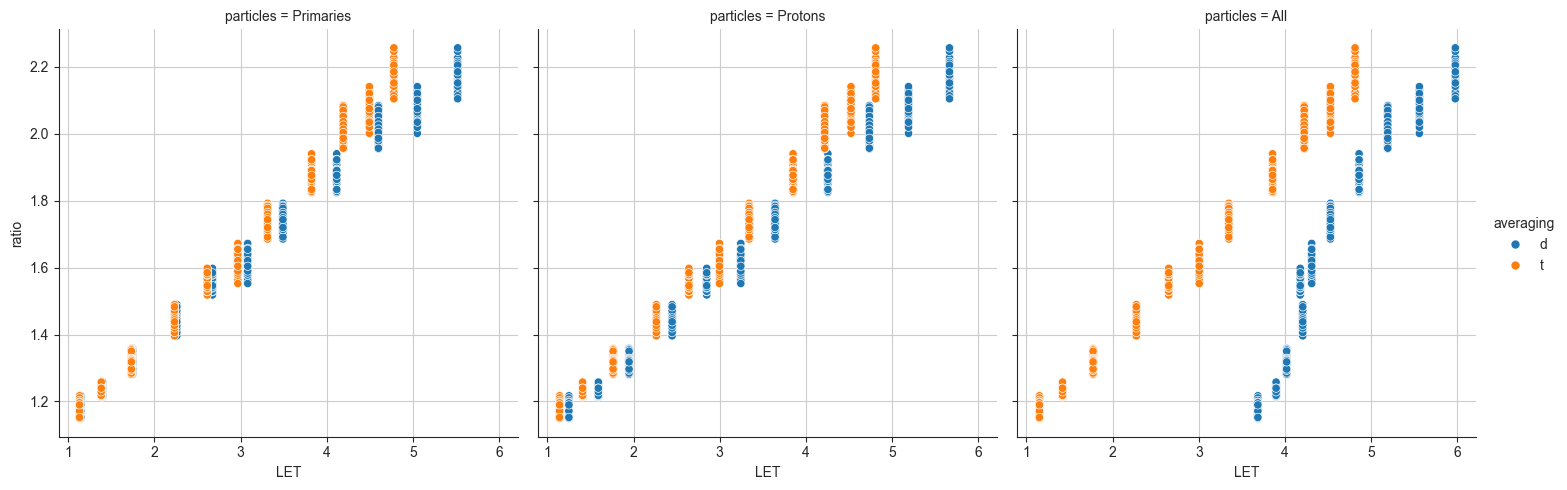

In [25]:
sns.relplot(data=df_ratio_melted, x="LET", y="ratio", hue="averaging", col="particles")

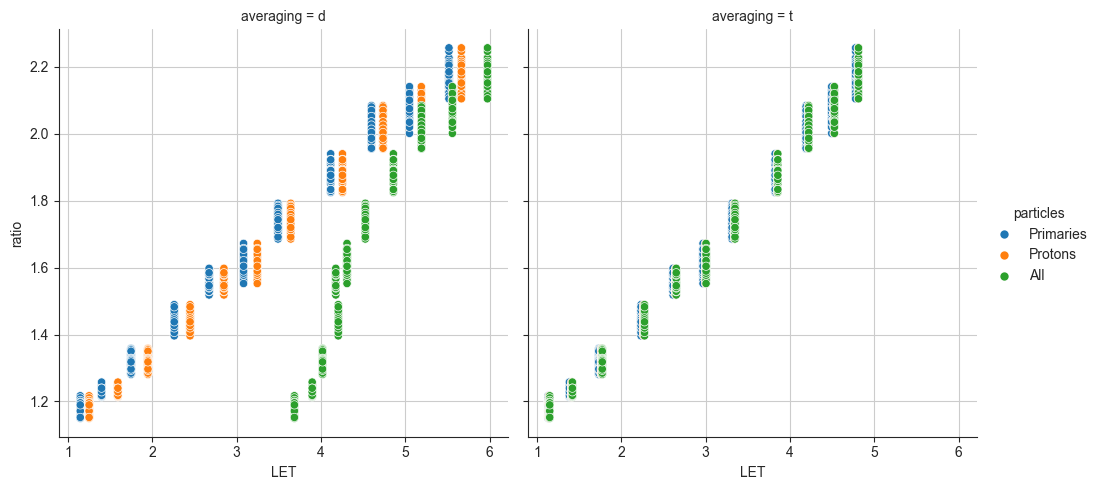

In [26]:
sns.relplot(data=df_ratio_melted, x="LET", y="ratio", hue="particles", col="averaging")